# Задача

# Введение
В Контуре мы много работаем с документами: арбитражные иски, госзакупки, исполнительные производства. В данном задании мы предлагаем вам сделать модель, которая поможет отделу госзакупок извлекать 
нужный кусок текста из документа для того, чтобы сформировать анкету заявки. То, какой именно фрагмент текста нужно извлечь, зависит от пункта анкеты, соответствующего документу.
Всего в каждом документе, с которыми вы будет работать, есть 1 из 2-х пунктов анкеты, по которым необходимо извлекать кусочки из текста:
- обеспечение исполнения контракта
- обеспечение гарантийных обязательств

Соответственно, ваша модель, принимая на вход `текст документа` и `наименование одного из двух пунктов`, должна возвращать `соответствующий кусочек текста из текста документа`.

# Данные

### train.json 
Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
    ```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```
  
### test.json

Для демонстрации работы модели используйте данные из файла `test.json`. В нем есть все те же поля, что и в файле `train.json`, кроме поля `extracted_part` - именно его вам и нужно будет добавить,
для того, чтобы мы смогли оценить качество вашей модели.

# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста. 
Обучив модель, добавьте в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`

**Подсказка**: изучив данные, вы можете заметить, что у части наблюдений отсутствует фрагмент текста к извлечению (пустая строка внутри поля `extracted_part` с `answer_start` и
`answer_end` равными нулю). Это означает, что в тексте документа нет нужного фрагмента текста, соответствующего пункту анкеты. Учтите это в обучении вашей модели и при формировании
файла с ответами.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически
   требуемому фрагменту.
2. Чистота кода, оформление и понятность исследования.

# Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.json` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.json` должен включать в себя колонки `id`, `text`, `label`, содержащие те же данные, что и исходный файл `test.json`, а также колонку `extracted_part` в том же
формате, что и в файле `train.json`
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

Успехов!

## Генерация датасетов

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import random
from spacy.lang.ru import Russian
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
from spacy import displacy


# Версии библиотек

In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# EDA

In [3]:
train_df = pd.read_json('dataset/train.json', orient='records')

In [4]:
train_df

id                                               text  \
0     809436509  Извещение о проведении открытого конкурса в эл...   
1     854885310  ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...   
2       4382157  Извещение о проведении электронного аукциона д...   
3     184555082  Извещение о проведении электронного аукциона д...   
4     211645258  Извещение о проведении электронного аукциона д...   
...         ...                                                ...   
1794  938335285  «УТВЕРЖДАЮ» Директор МУП "ПКП и ОРТ" _________...   
1795  214609521  ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...   
1796   94811748  ДОГОВОР ПОДРЯДА № _____ «___»___________20____...   
1797  903507299  ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...   
1798  926039184  Государственная корпорацИя по атомной энергии ...   

                                     label  \
0         обеспечение исполнения контракта   
1         обеспечение исполнения контракта   
2         обеспечение исполнения контракта   
3         обеспечение исполнения контракта   
4         обеспечение исполнения контракта   
...                                    ...   
1794  обеспечение гарантийных обязательств   
1795  обеспечение гарантийных обязательств   
1796  обеспечение гарантийных обязательств   
1797  обеспечение гарантийных обязательств   
1798  обеспечение гарантийных обязательств   

                                         extracted_part  
0     {'text': ['Размер обеспечения исполнения контр...  
1     {'text': ['Поставщик должен предоставить обесп...  
2     {'text': ['Размер обеспечения исполнения контр...  
3     {'text': ['Размер обеспечения исполнения контр...  
4     {'text': ['Размер обеспечения исполнения контр...  
...                                                 ...  
1794  {'text': ['Заказчиком установлено требование о...  
1795  {'text': [''], 'answer_start': [0], 'answer_en...  
1796  {'text': [''], 'answer_start': [0], 'answer_en...  
1797  {'text': [''], 'answer_start': [0], 'answer_en...  
1798  {'text': [''], 'answer_start': [0], 'answer_en...  

[1799 rows x 4 columns]

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1799 non-null   int64 
 1   text            1799 non-null   object
 2   label           1799 non-null   object
 3   extracted_part  1799 non-null   object
dtypes: int64(1), object(3)
memory usage: 56.3+ KB


In [6]:
train_df.isna().sum()

id                0
text              0
label             0
extracted_part    0
dtype: int64

In [7]:
train_df[['text',	'label'	]].duplicated().sum()

0

In [8]:

# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [9]:
print(train_df['extracted_part'].head(1).astype( str ))

0    {'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'], 'answer_start': [1279], 'answer_end': [1343]}
Name: extracted_part, dtype: object


In [10]:
obj = dict(train_df['extracted_part'].values[0])
print(obj['text'], obj['answer_start'],obj['answer_end'])

['Размер обеспечения исполнения контракта 6593.25 Российский рубль'] [1279] [1343]


In [11]:
print(train_df['text'].values[0])

Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 

In [12]:
result = [_.start() for _ in re.finditer('Размер обеспечения исполнения контракта 6593.25 Российский рубль', train_df['text'].values[0])] 
print(result[0])
print(result[0]+len('Размер обеспечения исполнения контракта 6593.25 Российский рубль'))



1279
1343


обеспечение исполнения контракта        0.549194
обеспечение гарантийных обязательств    0.450806
Name: label, dtype: float64


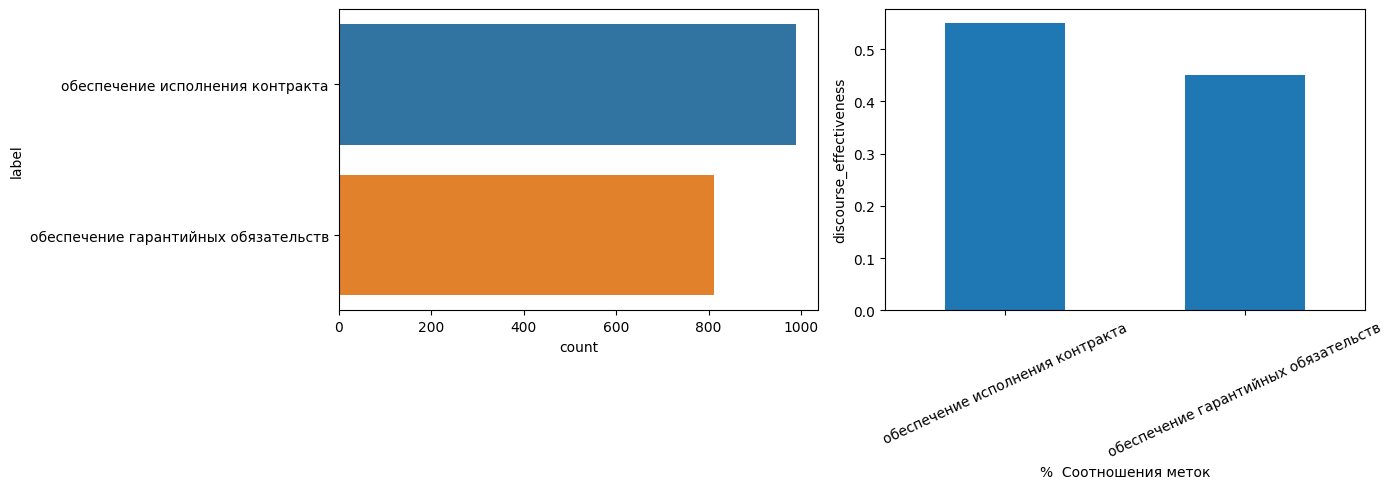

In [13]:
stats_target = train_df['label'].value_counts(normalize=True)
print(stats_target)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train_df,y='label')
plt.subplot(1,2,2)
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

In [14]:
def length_text(text):
    return len(text.split())

train_df['len_text'] = train_df['text'].apply(length_text)

In [15]:
train_df

id  \
0     809436509   
1     854885310   
2       4382157   
3     184555082   
4     211645258   
...         ...   
1794  938335285   
1795  214609521   
1796   94811748   
1797  903507299   
1798  926039184   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0                                                               Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ "Номер расчётного счёта" 00000000000

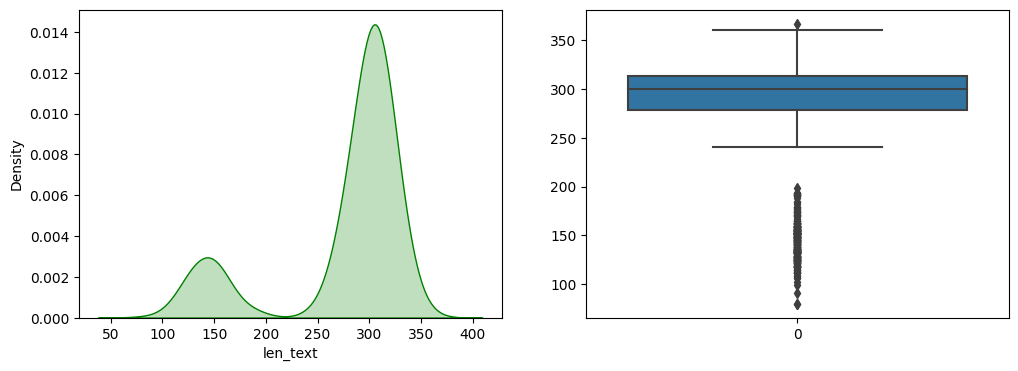

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(train_df['len_text'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(train_df['len_text'])
plt.show()

In [17]:
y_outliers = train_df[abs(zscore(train_df['len_text'])) >= 3 ]
y_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 868 to 1748
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2 non-null      int64 
 1   text            2 non-null      object
 2   label           2 non-null      object
 3   extracted_part  2 non-null      object
 4   len_text        2 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 96.0+ bytes


In [18]:
y_outliers

id  \
868   218092753   
1748  540120178   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
868   1 УТВЕРЖДАЮ Заместитель генерального директора по общим вопросам ООО «Нововоронежская АЭС- Авто» _______________________ С.В. Козлов «____»________________ 2022 ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ открытый одноэтапный запрос предложений в электронной форме без предварительного квалификационного отбора на право заключения договора на Поставку бензина и дизельного топлива на 2022 – 2023 г.г. ТОМ 1 «ОБЩАЯ И КОММЕРЧЕСКАЯ ЧАСТИ» 2022 2 СОДЕРЖАНИЕ Оглавление ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ .....................................................................................................1 СОДЕРЖАНИЕ .......................................................................................................................................2 1. ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАКУПКИ ...............................................................................3 ЧАСТЬ 1 ................................................................................................................................................10 2. ТРЕБОВА ТОМ 2 Техническое задание приведено в виде отдельного файла.   
1748  1 УТВЕРЖДАЮ: Заместитель генерального директора по общим вопросам ООО «Нововоронежская АЭС- Авто» _______________________ С.В. Козлов «____»________________ 2022 ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ открытый запрос предложений в электронной форме на право заключения договора на Поставку продуктов питания: молочная продукция г. Билибино. ТОМ 1 «ОБЩАЯ И КОММЕРЧЕСКАЯ ЧАСТИ» 2022 2 СОДЕРЖАНИЕ Оглавление ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ .....................................................................................................1 СОДЕРЖАНИЕ .......................................................................................................................................2 1. ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАКУПКИ ...............................................................................3 ЧАСТЬ 1 ................................................................................................................................................10 2. ТРЕБОВАНИЯ. ДОКУМЕНТЫ. СОСТАВ ЗАЯВКИ НА УЧАСТИЕ В ЗАКУПКЕ. ... ТОМ 2 Техническое задание приведено в виде отдельного файла.   

                                     label  \
868   обеспечение гарантийных обязательств   
1748  обеспечение гарантийных обязательств   

                                              extracted_part  len_text  
868   {'text': [''], 'answer_start': [0], 'answer_end': [0]}        80  
1748  {'text': [''], 'answer_start': [0], 'answer_end': [0]}        80

# Обнаружены выбросы, удалю их из обучающей выборки.

In [19]:
train_df=train_df.query('len_text!=80')

# Обучающий датасет формирование

In [20]:
train_df['text_str'] = train_df.apply(lambda row: ''.join(dict(row['extracted_part'])['text']), axis=1)
train_df['text_start'] = train_df.apply(lambda row: dict(row['extracted_part'])['answer_start'][0], axis=1)
train_df['text_end'] = train_df.apply(lambda row: dict(row['extracted_part'])['answer_end'][0], axis=1)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1797 entries, 0 to 1798
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1797 non-null   int64 
 1   text            1797 non-null   object
 2   label           1797 non-null   object
 3   extracted_part  1797 non-null   object
 4   len_text        1797 non-null   int64 
 5   text_str        1797 non-null   object
 6   text_start      1797 non-null   int64 
 7   text_end        1797 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 126.4+ KB


In [22]:
train_df

id  \
0     809436509   
1     854885310   
2       4382157   
3     184555082   
4     211645258   
...         ...   
1794  938335285   
1795  214609521   
1796   94811748   
1797  903507299   
1798  926039184   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0                                                               Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ "Номер расчётного счёта" 00000000000

In [23]:
train_df['target']=1

In [24]:
train_df['ent']=''
train_df['pre']=0

# EDA для искомых данных


In [25]:
train_df['len_text_str'] = train_df['text_str'].apply(length_text)

len_text_str
0       0.169727
7       0.149694
15      0.091820
5       0.080134
11      0.058431
13      0.041736
16      0.040623
12      0.037284
10      0.037284
14      0.037284
20      0.035058
8       0.028381
17      0.027268
18      0.021703
19      0.021703
21      0.020033
24      0.016138
22      0.016138
9       0.015582
23      0.011686
6       0.008347
26      0.006121
25      0.005008
31      0.004452
30      0.003895
29      0.003339
27      0.002782
28      0.002782
32      0.001669
4       0.001113
35      0.001113
36      0.000556
40      0.000556
39      0.000556

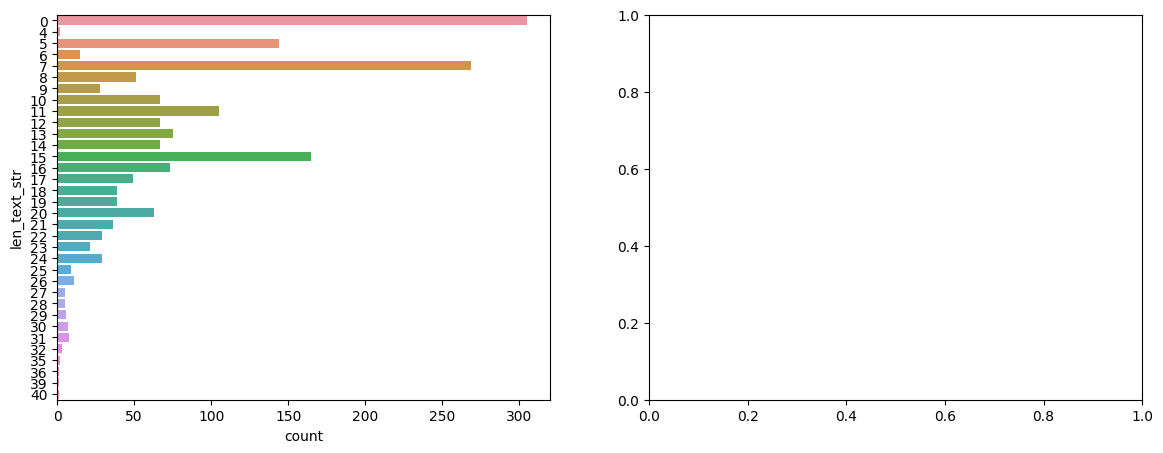

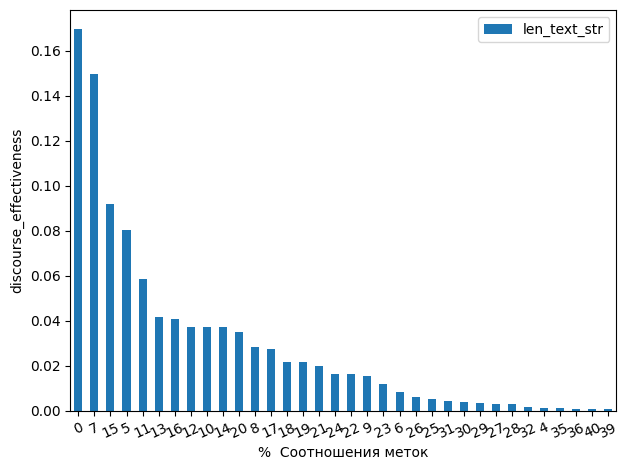

In [26]:
stats_target = train_df['len_text_str'].value_counts(normalize=True)
stats_target=pd.DataFrame(stats_target)
display(stats_target)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train_df,y='len_text_str')
plt.subplot(1,2,2)
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

In [27]:
stats_target.head(10)['len_text_str'].sum()

0.7440178074568726

In [28]:
for i in stats_target.index:
    print('________________Образец строки______________________-')
    print('Количество знаков = ',i, 'процент встречаемости= ',stats_target.loc[[i]].len_text_str*100)
    print(train_df.query('len_text_str==@i').head(1).text_str.values[0])
    print()
    print()
    print()

________________Образец строки______________________-
Количество знаков =  0 процент встречаемости=  0    16.972732
Name: len_text_str, dtype: float64




________________Образец строки______________________-
Количество знаков =  7 процент встречаемости=  7    14.969393
Name: len_text_str, dtype: float64
Размер обеспечения исполнения контракта 6593.25 Российский рубль



________________Образец строки______________________-
Количество знаков =  15 процент встречаемости=  15    9.18197
Name: len_text_str, dtype: float64
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта



________________Образец строки______________________-
Количество знаков =  5 процент встречаемости=  5    8.013356
Name: len_text_str, dtype: float64
Размер обеспечения исполнения контракта 10.00%



________________Образец строки______________________-
Количество знаков =  11 процент встречаемости=  11    5.843072
Name: len_text_str, dtype: float64
Обеспеч

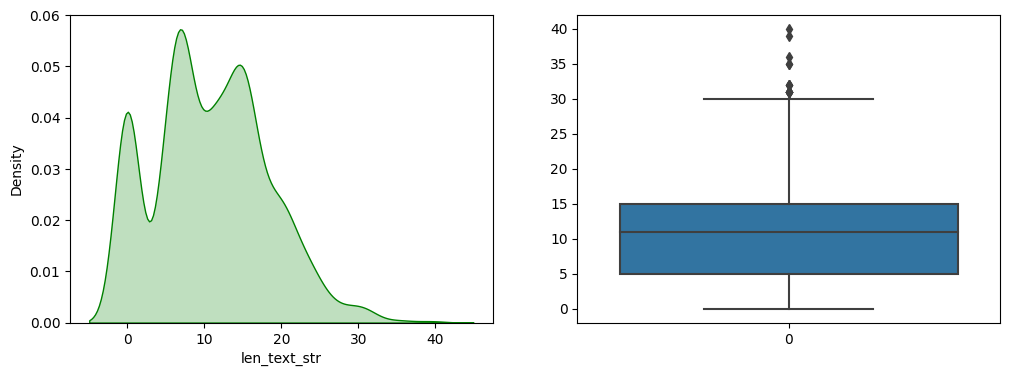

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(train_df['len_text_str'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(train_df['len_text_str'])
plt.show()

In [30]:
y_outliers = train_df[abs(zscore(train_df['len_text_str'])) >= 3 ]
y_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1174 to 1504
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5 non-null      int64 
 1   text            5 non-null      object
 2   label           5 non-null      object
 3   extracted_part  5 non-null      object
 4   len_text        5 non-null      int64 
 5   text_str        5 non-null      object
 6   text_start      5 non-null      int64 
 7   text_end        5 non-null      int64 
 8   target          5 non-null      int64 
 9   ent             5 non-null      object
 10  pre             5 non-null      int64 
 11  len_text_str    5 non-null      int64 
dtypes: int64(7), object(5)
memory usage: 520.0+ bytes


In [31]:
y_outliers

id  \
1174  792867528   
1386  360876826   
1412  513265910   
1473  127269228   
1504  873845087   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               text  \
1174                    Контракт № ________ на поставку эхолота гидрографического для нужд филиала ФГБУ «Балтийско-Арктическая техмордирекция» Калининградский – г. Калининград г. ____________ «__» __________ 202__ года Федеральное государственное бюджетное учреждение «Балтийско-Арктическая дирекция по  обеспечения может быть уменьшен в порядке и случаях, которые предусмотрены частями 7, 7.1, 7.2 и 7.3 статьи 96 Федерального закона № 44-ФЗ. Действие указанного пункта не распространяется на случаи, если Поставщиком предоставлена недостоверная (поддельная) независимая гарантия. 10.6. Срок возврата Заказчиком Поставщику денежных средств, внесенных в качестве обеспечения исполнения Контракта (если такая форма обеспечения исполнения Контракта применяется Поставщиком), в том числе части этих денежных средств в случае уменьшения размера обеспечения исполнения Контракта в соответствии с частями 7, 7.1, 7.2 статьи 96 Федерального закона № 44-ФЗ: не позднее 15 (пятнадцати) дней с даты исполнения Поставщиком обязательств, предусмотренных Контрактом, на счет, указанный Поставщиком. 10.7. В случае неиспо

# Обнаружены выбросы, удалю их из обучающей выборки.

In [32]:
train_df=train_df.query('len_text_str!=35')
train_df=train_df.query('len_text_str!=36')
train_df=train_df.query('len_text_str!=39')
train_df=train_df.query('len_text_str!=40')

# Вывод.
* Данные готовы к исследованию. 
* обнаружены и удалены выбросы в текстах и искомых фрагментах.
* Искомые фрагменты в большинстве случаев однотипны и могут быть описаны регулярными выражениями или паттернами nlp.
* Accuracy не прибегая к машинному обучению может составлять до 0.74, простым написанием 10 регулярных выражений или паттернов nlp.
* Учитывая характер разметки данных, будем использовать spacy.

# Сформируем кросвалидационные выборки.

In [33]:
X = train_df
y = train_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

In [34]:
X_train.shape

(896, 12)

In [35]:
y_train.shape

(896, 12)

In [36]:
X_test.shape

(896, 12)

In [37]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 187 to 1786
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              896 non-null    int64 
 1   text            896 non-null    object
 2   label           896 non-null    object
 3   extracted_part  896 non-null    object
 4   len_text        896 non-null    int64 
 5   text_str        896 non-null    object
 6   text_start      896 non-null    int64 
 7   text_end        896 non-null    int64 
 8   target          896 non-null    int64 
 9   ent             896 non-null    object
 10  pre             896 non-null    int64 
 11  len_text_str    896 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 91.0+ KB


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 0 to 1798
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1792 non-null   int64 
 1   text            1792 non-null   object
 2   label           1792 non-null   object
 3   extracted_part  1792 non-null   object
 4   len_text        1792 non-null   int64 
 5   text_str        1792 non-null   object
 6   text_start      1792 non-null   int64 
 7   text_end        1792 non-null   int64 
 8   target          1792 non-null   int64 
 9   ent             1792 non-null   object
 10  pre             1792 non-null   int64 
 11  len_text_str    1792 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 182.0+ KB


# nlp 

# Сформируем TRAIN_DATA

In [39]:
TRAINING_DATA=[]
for index, row in  train_df.iterrows():
    if row['text_start']:
        TRAINING_DATA.append((row['text'],{"entities":[(row['text_start'],row['text_end'],row['label'])]}))
    else:
        TRAINING_DATA.append((row['text'],{"entities":[]}))

In [40]:
TRAINING_DATA

[('Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч.

In [41]:
#re.finditer(substr, str1)] 
print(train_df['extracted_part'].head(1).astype( str ))

0    {'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'], 'answer_start': [1279], 'answer_end': [1343]}
Name: extracted_part, dtype: object


# Обучим  модель.

In [ ]:
nlp = spacy.blank("ru")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)
ner.add_label("обеспечение исполнения контракта")
ner.add_label("обеспечение гарантийных обязательств")
nlp.begin_training()
nlp=spacy.load("model4")

for i in range(5,6):
    random.shuffle(TRAINING_DATA)
    for batch in spacy.util.minibatch(TRAINING_DATA):
        texts = [text for text, annotation in batch]
        annotations = [annotation for text, annotation in batch]
        nlp.update(texts, annotations)
    
        #Валидация 
    for index, row in X_train.iterrows():
        doc = nlp(row['text'])
        if doc.ents:
            X_train['ent'].loc[index]=str(doc.ents[0])
        else:
            X_train['ent'].loc[index]=''
        
        
    for index, row in X_train.iterrows():
        if X_train['ent'].loc[index]==X_train['text_str'].loc[index]:
            X_train['pre'].loc[index]=1
        
    print('Эпоха', i, )
    print('accuracy обучающей выборки', accuracy_score(X_train['target'], X_train['pre']))
    print('-----------------------------------------------------------------------------')
        
        
        
        
    for index, row in X_test.iterrows():
        doc = nlp(row['text'])
        if doc.ents:
            X_test['ent'].loc[index]=str(doc.ents[0])
        else:
            X_test['ent'].loc[index]=''
        
        
    for index, row in X_test.iterrows():
        if X_test['ent'].loc[index]==X_test['text_str'].loc[index]:
            X_test['pre'].loc[index]=1
        
    print('Эпоха', i, )
    print('accuracy обучающей 2  выборки', accuracy_score(X_test['target'], X_test['pre']))
    print('-----------------------------------------------------------------------------')
        #Валидация
        
    nlp.to_disk("model"+str(i))

Эпоха 5
accuracy обучающей выборки 0.9542410714285714
-----------------------------------------------------------------------------


# Вывод:
    Обучение проходило в два этапа, сначала с валидационной выборкой. Переобучения не обнаружено!
    Затем модель доучена на оставшихся данных из валидационной выборки.
    
    Обученная spacy модель умеет находить в тексте именованные сущности 2-х типов: 'обеспечение гарантийных      обязательств', 'обеспечение исполнения контракта'.

In [ ]:
nlp=spacy.load("model4")

In [ ]:

doc = nlp(
'''УТВЕРЖДЕНО решением Единой закупочной комиссии ООО «Технический заказчик Фонда развития территорий» Извещение о проведении открытого конкурса в электронной форме и документация о проведении открытого конкурса в электронной форме на выполнение ия участникам закупки документации о закупке – с 02.09.2022 по 21.09.2022 13.6 В случае если запрос на предоставление документации о закупке поступил на почтовый адрес, указанный в пункте 2 настоящего извещения, заказчик, организатор закупки предоставляет документацию о закупке по адресу, указанному в пункте 2 настоящего извещения. 13.7 В случае если запрос на предоставление документации о закупке поступил на адрес электронной почты, указанный в пункте 2 настоящего извещения, заказчик, организатор закупки направляет документацию о закупке на адрес электронной почты, указанный в запросе на предоставление документации о закупке. 13.8 Документация о закупке заинтересованному лицу предоставляется бесплатно. 14. Информация о размере обеспечения заявок на участие в закупке 14.1 Обеспечение заявки – не устанавливается 14.2 Информация о порядке и способе обеспечения заявок на участие в закупке указана в п. 4 документации о закупке. 15. Информация о размере обеспечения исполнения договора 15.1 Обеспечение исполнения договора устанавливается в размере 2% - 43 375 595 (сорок три миллиона триста семьдесят пять тысяч пятьсот девяносто пять) рублей, 65 копеек. 15.2 Информация о порядке и способе обеспечения исполнения договора на участие в закупке указана в п. 5 документации о закупке. 15.3 Размер обеспечения гарантийных обязательств установлен в размере 2% (два процента) от цены договора. 15.4 Порядок и способ предоставления обеспечения гарантийных обязательств указан в п.8.4.1. Проекта договора. 16. Антидемпинговые меры 16.1. Под демпингом понимается предложение цены, сделанное участником закупки, на 25 (двадцать пять) процентов и более ниже начальной (максимальной) цены договора (цены единицы услуги) (далее – Предложение с признаками демпинга), за исключением случаев предоставления участником закупки в составе заявки информации о наличии у него опыта поставки товаров, выполнения работ, оказания услуг по предмету закупки на сумму не менее 50 (пятидесяти) процентов от начальной (максимальной) цены договора/предельной цены договора, устан Руководитель/уполномоченный представитель участника закупки или каждого лица, выступающего на стороне коллективного участника закупки ________________ (Фамилия И.О.) (реквизиты документа, подтверждающего полномочия) (подпись)''')

for ent in doc.ents:
    if ent.label_ == "обеспечение исполнения контракта" and ent.start != 0:
        print(ent.text, ent.label_)



In [ ]:
ents = [(e.text, e.label_,) for e in doc.ents]
print(ents)  

In [ ]:

displacy.render(doc, style='ent', jupyter=True)

In [ ]:
nlp.get_pipe("ner").labels

# Валидация на всей обучающей выборке

In [ ]:
for index, row in train_df.iterrows():
    string=''
    doc = nlp(row['text'])
    if doc.ents:
        for i in doc.ents:
            if i.label_==row['label']:
                string=i.text
        print(string)
        #test_df['ent'].loc[index]=str(doc.ents[0])
        train_df['ent'].loc[index]=string
    else:
        train_df['ent'].loc[index]=''
    

In [ ]:
for index, row in train_df.iterrows():
        if train_df['ent'].loc[index]==train_df['text_str'].loc[index]:
            train_df['pre'].loc[index]=1
            
    
    

In [ ]:

accuracy_score(train_df['target'], train_df['pre'])

In [ ]:
train_df.query('pre==0')[['text_str','ent']].info()

# Генерация ответа

In [ ]:
test_df = pd.read_json('dataset/test.json', orient='records')
test_df['ent']=''
test_df['answer_start']=0
test_df['answer_end']=0

In [ ]:
test_df

# В генерации ответа учтем, что в одном текстовом фрагменте могут находиться 2 entity!

In [ ]:
for index, row in test_df.iterrows():
    result=-1
    doc = nlp(row['text'])
    string=''
    if doc.ents:
        for i in doc.ents:
            if i.label_==row['label']:
                string=i.text
                result = test_df['text'].loc[index].rfind(string)
                
        print(row['label'])
        print(index)
        print(string)
        #test_df['ent'].loc[index]=str(doc.ents[0])
        test_df['ent'].loc[index]=string
        if result!=-1:
            print(result)
            test_df['answer_start'].loc[index]=result
            test_df['answer_end'].loc[index]=result+len(string)
        
        
    else:
        test_df['ent'].loc[index]=''

In [ ]:
test_df.head(318)

In [ ]:
test_df.info()

In [ ]:
test_df.query('answer_start==0')[['text','ent']].info()

In [ ]:
test_df.query('answer_start==0')[['text','label','ent']]

In [ ]:
predictions=[]
for index, row in test_df.iterrows():
    predictions.append({
    "id": row['id'],
    "text":row['text'],
    "label": row['label'],
    "extracted_part": {
      "text": [
        row['ent']
      ],
      "answer_start": [
        row['answer_start']
      ],
      "answer_end": [
        row['answer_end']
      ]
    }
  })
    

In [ ]:
predictions[0]

In [ ]:
i={
    "id": 809436509,
    "text": "Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ \"Номер расчётного счёта\" 00000000000000000000 \"Номер лицевого счёта\" См. прилагаемые документы \"БИК\" 000000000 \"Наименование кредитной организации\" \"Номер корреспондентского счета\" Обеспечение исполнения контракта Требуется обеспечение исполнения контракта Размер обеспечения исполнения контракта 6593.25 Российский рубль Порядок обеспечения исполнения контракта, требования к обеспечению Исполнение контракта, гарантийные обязательства могут обеспечиваться предоставлением независимой гарантии, соответствующей требованиям ст. 45 Федерального закона № 44-ФЗ, или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, гарантийных обязательств, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона № 44-ФЗ участником закупки, с которым заключается контракт, самостоятельно. При этом срок действия независимой гарантии должен превышать предусмотренный контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со ст. 95 Федерального закона № 44-ФЗ. Порядок предоставления и требования о Информация и документы, подтверждающие соответствие участников закупки дополнительным требованиям: 1) исполненный договор; 2) акт приемки оказанных услуг и (или) поставленных товаров, подтверждающий цену оказанных услуг и (или) поставленных товаров 4",
    "label": "обеспечение исполнения контракта",
    "extracted_part": {
      "text": [
        "Размер обеспечения исполнения контракта 6593.25 Российский рубль"
      ],
      "answer_start": [
        1279
      ],
      "answer_end": [
        1343
      ]
    }
  },

In [ ]:
i[0]

In [ ]:
import json
with open('predictions.json', 'w', encoding='utf-8') as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)

## Проверка типов данных в ответе!

In [ ]:
def check_valid_JSOn(filename):
    try:
        with open(filename) as file:
         parse_json = json.load(file)
         #print(parse_json) 
         return True
    except ValueError as e:        
        return False
 
print('Валидность :',check_valid_JSOn('dataset/train.json'))
print('валидность :',check_valid_JSOn('predictions.json'))


In [ ]:
f = open('dataset/train.json')
data_train = json.load(f)
f.close()
print(data_train[0])  # or `print data['two']` in Python 2

In [ ]:
print(type(data_train[0]['id']))
print(type(data_train[0]['text']))
print(type(data_train[0]['label']))
print(type(data_train[0]['extracted_part']['text']))
print(type(data_train[0]['extracted_part']['answer_start']))
print(type(data_train[0]['extracted_part']['answer_end']))
print(type(data_train[0]['extracted_part']['text'][0]))
print(type(data_train[0]['extracted_part']['answer_start'][0]))
print(type(data_train[0]['extracted_part']['answer_end'][0]))

In [ ]:
f = open('predictions.json')
data_test = json.load(f)
f.close()
print(data_test[0]) 

In [ ]:
print(type(data_test[0]['id']))
print(type(data_test[0]['text']))
print(type(data_test[0]['label']))
print(type(data_test[0]['extracted_part']['text']))
print(type(data_test[0]['extracted_part']['answer_start']))
print(type(data_test[0]['extracted_part']['answer_end']))
print(type(data_test[0]['extracted_part']['text'][0]))
print(type(data_test[0]['extracted_part']['answer_start'][0]))
print(type(data_test[0]['extracted_part']['answer_end'][0]))

### Вывод json валиден, типы данных совпадают

# EDA реузультатов прогнозирования

In [ ]:
test_df['len_text_str'] = test_df['ent'].apply(length_text)
stats_target = test_df['len_text_str'].value_counts(normalize=True)
stats_target=pd.DataFrame(stats_target)
display(stats_target)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=test_df,y='len_text_str')
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(test_df['len_text_str'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(test_df['len_text_str'])
plt.show()

In [ ]:
for index, row in test_df.iterrows():
    print(index)
    doc = nlp(row['text'])
    displacy.render(doc, style='ent', jupyter=True)

## Сделано:
   
   * Данные загружены, предобработаны, произведено EDA.
   * обнаружены и удалены выбросы в текстах и искомых фрагментах.
   * Искомые фрагменты в большинстве случаев однотипны и могут быть описаны регулярными выражениями или паттернами nlp.
   * Accuracy не прибегая к машинному обучению может составлять до 0.74, простым написанием 10 регулярных выражений или паттернов nlp.
   * Учитывая характер разметки данных, будем использовать spacy.
   
## Обучение

   * Обучение модели проходило на представленных в train данных в два этапа, сначала с валидационной выборкой. Переобучения не обнаружено! Затем модель доучена на оставшихся данных из валидационной выборки.

   * Обученная spacy модель умеет находить в тексте именованные сущности 2-х типов: 'обеспечение гарантийных      обязательств', 'обеспечение исполнения контракта'.
   
   

## Вывод: 
   * В целом модель отрабатывает и находит сущности.
   * Точность на обучающей выборке до 96%.
   * Тестовую по правилам в обучении не задействовали.
   * В наших ответах на 10% больше нулевых результатов, чем в обучающей выборке. Причем при визульном осмотре таких образцов извлечение сущности кажется возможным.
   * Остаются вопросы к разметке данных. Некоторые сущности отличаются только бессмысленными знаками препенания и могут сильно уронить accuracy.
   * predictions.json валиден, формат соответствует train.json.
   
### Зависимости в requirements.txt.